In [131]:
import pandas as pd
import time
from collections import Counter
from nltk import word_tokenize 
# https://www.nltk.org/_modules/nltk/tokenize.html
# Tokenizers divide strings into lists of substrings.  For example,
# tokenizers can be used to find the words and punctuation in a string
import nltk
import numpy as np
#from wordcloud import WordCloud, STOPWORDS # STOPWORDS
from nltk.corpus import stopwords # stopwords 
import matplotlib.pyplot as plt
import seaborn as sns
import string
import pickle

from sklearn.feature_extraction.text import CountVectorizer 
# see https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# Convert a collection of text documents to a matrix of token counts
#This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix.
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn import svm

In [132]:
def remove_values_from_list(the_list, val):
    return [value for value in the_list if value != val]

def my_preprocess(sentence):
    sentence = str(sentence)
    sentence = sentence.lower() # Step 1: transfer data to lower-case strings
    list_words = word_tokenize(sentence) #Step 2: break the sentences into a list of words
    list_words = remove_values_from_list(list_words, '$') # Step 3: $hashtag$ and $url$ must be filtered
    list_words = remove_values_from_list(list_words, 'hashtag')
    list_words = remove_values_from_list(list_words, 'url')
    # Step 4: filter punctuations
    list_words_return = []
    for s in list_words:
        if s not in string.punctuation:
            list_words_return.append(s)
    # Step 5: some rows might disapear, I give " " to them
    if len(list_words_return) == 0:
        list_words_return.append(" ")
    return (' '.join(list_words_return)) # return a string which words seperated by ' '

def my_preprocess2(sentence):
    sentence = str(sentence)
    sentence = sentence.lower() # Step 1: transfer data to lower-case strings
    list_words = word_tokenize(sentence) #Step 2: break the sentences into a list of words
    list_words = remove_values_from_list(list_words, '$') # Step 3: $hashtag$ and $url$ must be filtered
    list_words = remove_values_from_list(list_words, 'hashtag')
    list_words = remove_values_from_list(list_words, 'url')
    # Step 4: filter punctuations
    list_words_return = []
    for s in list_words:
        if s not in string.punctuation:
            list_words_return.append(s)
    # Step 5: some rows might disapear, I give " " to them
    if len(list_words_return) == 0:
        list_words_return.append(" ")
    return (list_words_return) # return a list of words

def fit_model(model,train_features,test_features,y_train,y_test):
    model.fit(train_features,y_train)
    acc = model.score(test_features,y_test)
    predictions = model.predict(test_features)
    cm = metrics.confusion_matrix(y_test, predictions)
    if (cm[0][0] + cm[0][1] == 0):
        pre = 0
    else:
        pre = (cm[0][0]+0.0) / (cm[0][0] + cm[0][1])
    if (cm[0][0] + cm[1][0] == 0):
        rec = 0
    else:    
        rec = (cm[0][0]+0.0) / (cm[0][0] + cm[1][0])
    
    return acc,pre,rec

def print_dict(dictionary):
    for key,value in dictionary.items():
        print(key,"  ","  ".join(str(round(x,3)) for x in value))
    return None

# Section A: read in data and do some preprocessing

In [133]:
# read in train data
start_time = time.time()
path = "/mnt/c/Users/Administrator.DESKTOP-OHBO1TS/Desktop/github/BlockchainTweetAnalyses-master/" + \
"BlockchainTweetAnalyses-master/training_data/"
df = pd.read_excel(path + "training_set_dec9.xlsx")
print("df.shape",df.shape)
print("===== before fitering =====")
print(df['full_text'][0])
print("this cell takes time:",round(time.time() - start_time,3),"s")

df.shape (10381, 12)
===== before fitering =====
get started with $HASHTAG$ - check out $URL$ and install the client at: $URL$
this cell takes time: 1.334 s


In [134]:
# filtering data
start_time = time.time() 
inputDF = df['full_text'].apply(lambda x: my_preprocess(x) )
inputDF = pd.Series(inputDF)
print("I have filtered $hashtag$ and $url$")
print("I have filtered all punctuations, these are:",string.punctuation)
print("===== after fitering =====")
print("each row has datatype= ",type(inputDF[0]))
print(inputDF[0])
print("this cell takes time:",round(time.time() - start_time,3),"s")

I have filtered $hashtag$ and $url$
I have filtered all punctuations, these are: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
===== after fitering =====
each row has datatype=  <class 'str'>
get started with check out and install the client at
this cell takes time: 3.04 s


# Section A-2 build the word library

In [135]:
start_time = time.time()
inputDF_words = df['full_text'].apply(lambda x: my_preprocess2(x) )
print("this cell takes time:",round(time.time() - start_time,3),"s")

this cell takes time: 2.831 s


### remove punctuations, and numbers from bag_of_words

In [136]:
start_time = time.time()

bag_of_words = []
for el in inputDF_words:
    bag_of_words.extend(el)
bag_of_words = list(np.unique(bag_of_words))

print("There are ",len(bag_of_words)," unique words in bag_of_words")
bag_of_words.sort()

starting_words = list(string.ascii_lowercase[:26]) # a-z
ban_words = [str(i) for i in range(0,10)] # 0-9
ban_punctuation = list(string.punctuation)

bag_of_words_new = []
for i in range(len(bag_of_words)):
    #if (i % 100 ==0):
        #print("dealing with word count = ",i)
    words = bag_of_words[i]
    flag1 = True
    flag2 = False
    flag3 = True
    
    for num in ban_words:
        if num in words:
            flag1 = False
            break
    
    for punct in ban_punctuation:
        if punct in words:
            flag3 = False
            break
    
    if words[0] in starting_words:
        flag2 = True
    
    if flag1 and flag2 and flag3:
        bag_of_words_new.append(words)
    else:
        continue
bag_of_words_new = list(np.unique(bag_of_words_new))

print("After filtering, there are ",len(bag_of_words_new)," unique words in bag_of_words")
print("this cell takes time:",round(time.time() - start_time,3),"s")

There are  12225  unique words in bag_of_words
After filtering, there are  10209  unique words in bag_of_words
this cell takes time: 0.307 s


## remove stopping words according to nltk

In [137]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/zhiyuan8/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [142]:
bag_of_words_new2 = [word for word in bag_of_words_new2 if word not in stopwords] # filter by nltk

bag_of_words_new2 = list(np.unique(bag_of_words_new2))
print("After filtering, there are ",len(bag_of_words_new2)," unique words in bag_of_words_new2")

# save to file
f = open(path +  'Zhiyuan_Li_word_dict.csv','w+')
for t in bag_of_words_new2:
    f.write(t + '\n')
f.close()
print("finished saving file")

After filtering, there are  10069  unique words in bag_of_words_new2
finished saving file


# Section B: use CountVectorizer, train on different models and compare performance

In [155]:
# read bag of words
bag_of_words = list()

f = open(path +  'Zhiyuan_Li_word_dict.csv','r')
for x in f.readlines():
    bag_of_words.append(x[0:-1])
f.close()
print("finished reading bag_of_words")

assert len(bag_of_words) == len(np.unique(bag_of_words)), "bag_of_words must be unique dict of words!"

finished reading bag_of_words


In [156]:
# define the word counting model [IMPORTANT!!!]
# see https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# Convert a collection of text documents to a matrix of token counts
#This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix.

Zhiyuan_count_vec = CountVectorizer(analyzer = "word",vocabulary=bag_of_words)

## an example of using CountVectorizer

In [157]:
start_time = time.time()
outputDF = df['Disrupt traditional players']

x_train,x_test,y_train,y_test = train_test_split(inputDF,outputDF,shuffle=True,random_state=1,test_size=0.2)
train_features = Zhiyuan_count_vec.fit_transform(x_train)
test_features = Zhiyuan_count_vec.transform(x_test)

clf_svm = svm.SVC(gamma='scale')
clf_svm.fit(train_features,y_train)
new_text = ['I am so tired and lack of sleep ...']
new_features = Zhiyuan_count_vec.fit_transform(new_text)
prediction = clf_svm.predict(new_features)

print("train_features & test_features becomes:",type(train_features))
print("prediction for my words: ", prediction)
print("this cell takes time:",round(time.time() - start_time,3),"s")

train_features & test_features becomes: <class 'scipy.sparse.csr.csr_matrix'>
prediction for my words:  [0]
this cell takes time: 1.204 s


## all ML models I used

In [122]:
clf_tree = DecisionTreeClassifier()
clf_NB = MultinomialNB()
clf_LR = LogisticRegression(solver='lbfgs') # use default parameters
clf_RF = RandomForestClassifier(n_estimators=100)
clf_svm = svm.SVC(gamma='scale')
clf_nn = MLPClassifier(solver='lbfgs',activation='logistic',alpha=1e-5,hidden_layer_sizes=(6,4,2), random_state=0)
clf_LDA = LinearDiscriminantAnalysis()
clf_QDA = QuadraticDiscriminantAnalysis()

In [123]:
def fit_model(model,train_features,test_features,y_train,y_test):
    model.fit(train_features,y_train)
    acc = model.score(test_features,y_test)
    predictions = model.predict(test_features)
    cm = metrics.confusion_matrix(y_test, predictions)
    if (cm[0][0] + cm[0][1] == 0): # for the case where denominator is 0
        pre = 0
    else:
        pre = (cm[0][0]+0.0) / (cm[0][0] + cm[0][1])
    if (cm[0][0] + cm[1][0] == 0): # for the case where denominator is 0
        rec = 0
    else:    
        rec = (cm[0][0]+0.0) / (cm[0][0] + cm[1][0])
     
    # F1 = 2 * (precision * recall) / (precision + recall)
    if pre + rec == 0:
        F1 = 0
    else:
        F1 = 2 * (pre * rec) / (pre + rec)
    return acc,pre,rec,F1

def save_winning_model(model,key_winner):
    filename = path + column + '_model_' + key_winner + '.sav'
    pickle.dump(clf_tree, open(filename, 'wb'))
            

# Start fitting

==== I am dealing with the column:  Disrupt traditional players


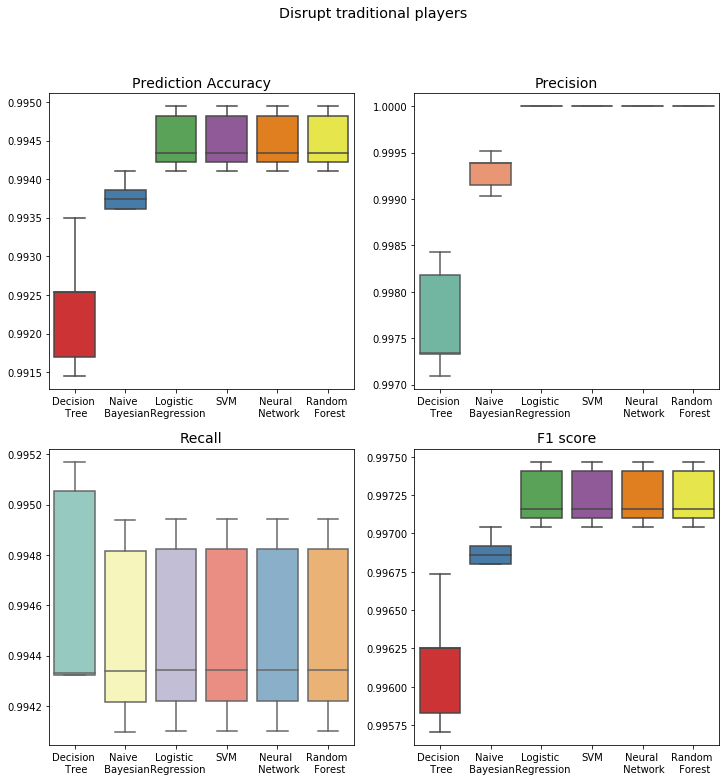

model= tree Mean of F1_score_result0 is:  0.9961554877545067  key_winner= svm
model= NB Mean of F1_score_result0 is:  0.9968837486900076  key_winner= tree
model= LR Mean of F1_score_result0 is:  0.9972349724253254  key_winner= NB
model= svm Mean of F1_score_result0 is:  0.9972349724253254  key_winner= LR
model= nn Mean of F1_score_result0 is:  0.9972349724253254  key_winner= LR
model= RF Mean of F1_score_result0 is:  0.9972349724253254  key_winner= LR
*****winning model is:  LR  objective(F1 score)=  0.9972349724253254 *****
finished dealing  Disrupt traditional players  , it takes time  11.835 s
==== I am dealing with the column:  Complement traditional players


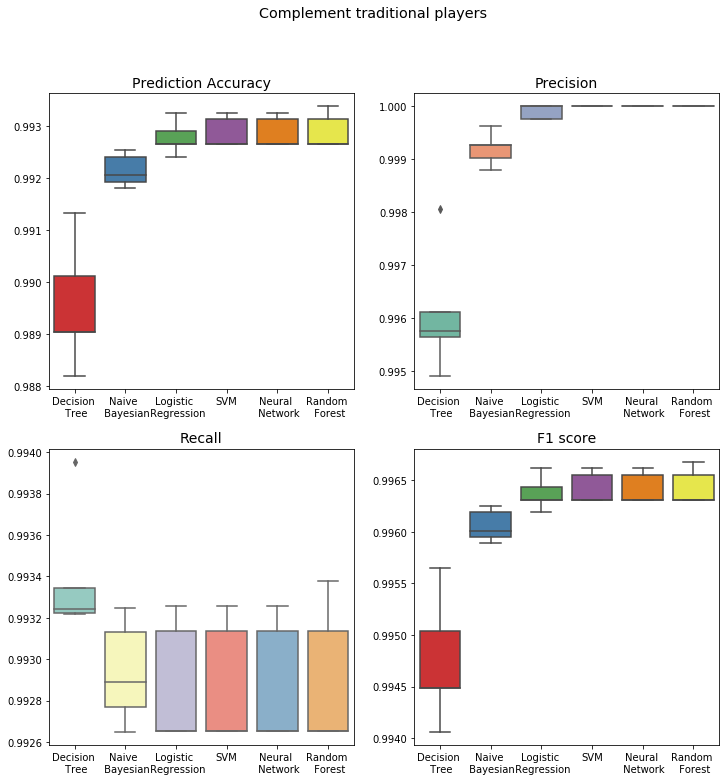

model= tree Mean of F1_score_result0 is:  0.9947434698590729  key_winner= svm
model= NB Mean of F1_score_result0 is:  0.9960588845137426  key_winner= tree
model= LR Mean of F1_score_result0 is:  0.9963746018387356  key_winner= NB
model= svm Mean of F1_score_result0 is:  0.996423115454459  key_winner= LR
model= nn Mean of F1_score_result0 is:  0.996423115454459  key_winner= svm
model= RF Mean of F1_score_result0 is:  0.9964351569832672  key_winner= svm
*****winning model is:  RF  objective(F1 score)=  0.9964351569832672 *****
finished dealing  Complement traditional players  , it takes time  16.813 s
==== I am dealing with the column:  Differentiate from new players


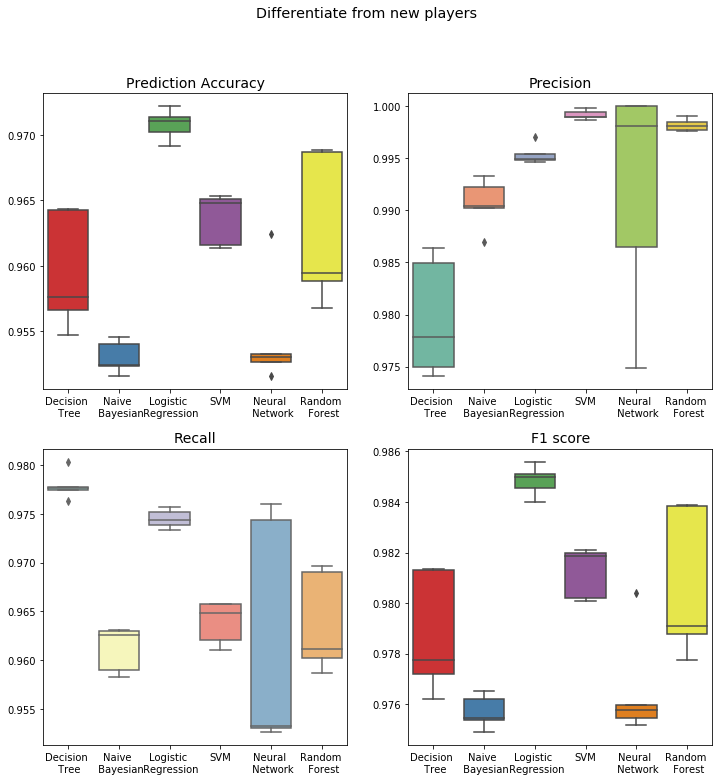

model= tree Mean of F1_score_result0 is:  0.9787615069462324  key_winner= svm
model= NB Mean of F1_score_result0 is:  0.9756940467536765  key_winner= tree
model= LR Mean of F1_score_result0 is:  0.9848394431016103  key_winner= tree
model= svm Mean of F1_score_result0 is:  0.9812533884091101  key_winner= LR
model= nn Mean of F1_score_result0 is:  0.9765463219878825  key_winner= LR
model= RF Mean of F1_score_result0 is:  0.980666157094662  key_winner= LR
*****winning model is:  LR  objective(F1 score)=  0.9848394431016103 *****
finished dealing  Differentiate from new players  , it takes time  28.719 s
==== I am dealing with the column:  Collaborate with new players


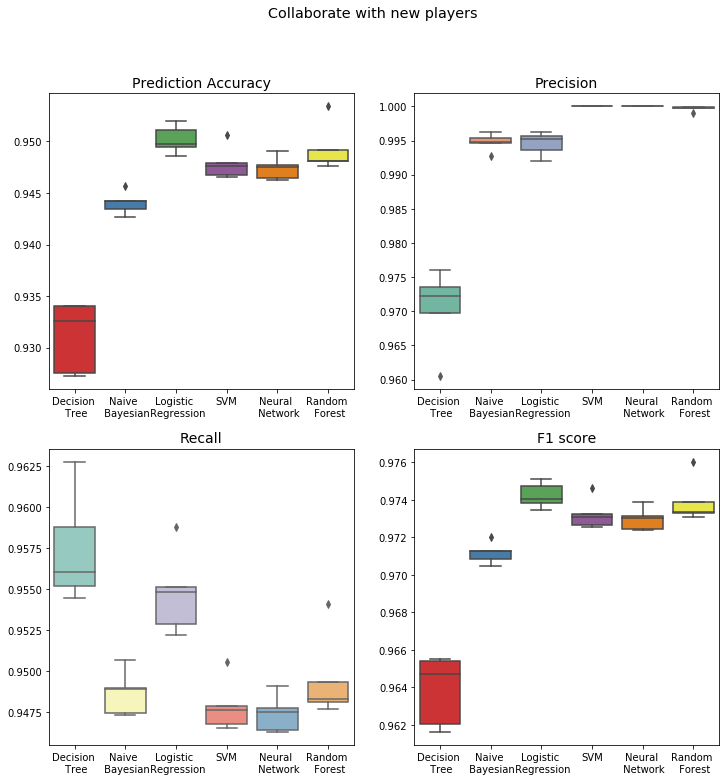

model= tree Mean of F1_score_result0 is:  0.963867293432858  key_winner= svm
model= NB Mean of F1_score_result0 is:  0.9711766806125988  key_winner= tree
model= LR Mean of F1_score_result0 is:  0.9742412487051915  key_winner= NB
model= svm Mean of F1_score_result0 is:  0.9732328708761045  key_winner= LR
model= nn Mean of F1_score_result0 is:  0.9729920823234502  key_winner= LR
model= RF Mean of F1_score_result0 is:  0.9739232447432935  key_winner= LR
*****winning model is:  LR  objective(F1 score)=  0.9742412487051915 *****
finished dealing  Collaborate with new players  , it takes time  24.808 s
==== I am dealing with the column:  Build own community


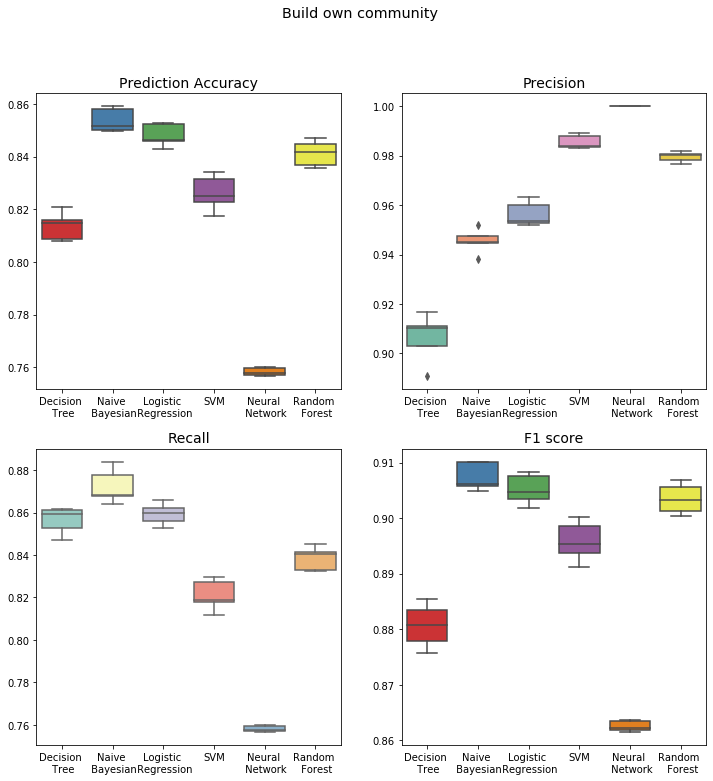

model= tree Mean of F1_score_result0 is:  0.8806827476526043  key_winner= svm
model= NB Mean of F1_score_result0 is:  0.9074231773755106  key_winner= tree
model= LR Mean of F1_score_result0 is:  0.9051942105919684  key_winner= NB
model= svm Mean of F1_score_result0 is:  0.8958449664203074  key_winner= NB
model= nn Mean of F1_score_result0 is:  0.8625306482542887  key_winner= NB
model= RF Mean of F1_score_result0 is:  0.9034554071545662  key_winner= NB
*****winning model is:  NB  objective(F1 score)=  0.9074231773755106 *****
finished dealing  Build own community  , it takes time  38.708 s
==== I am dealing with the column:  Differentiation without a Comparison


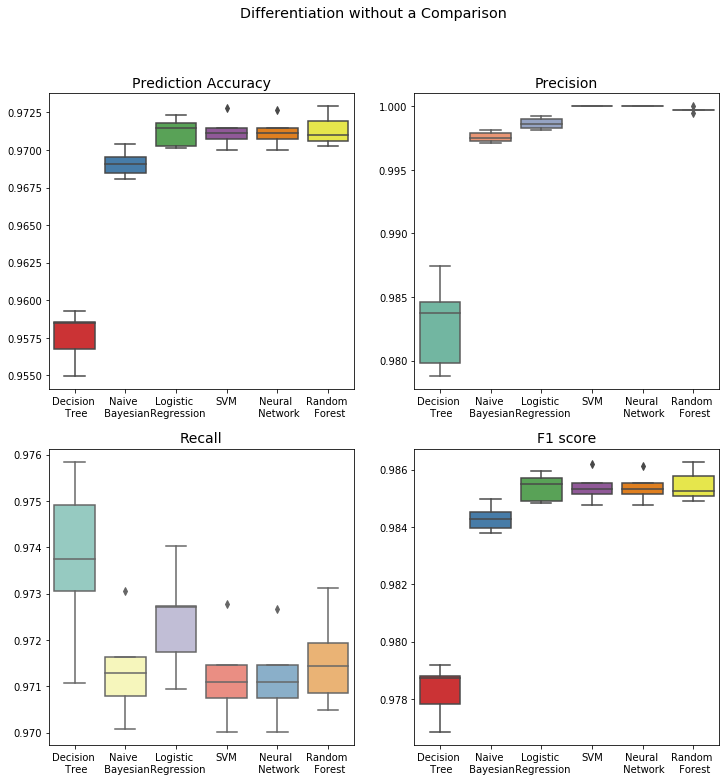

model= tree Mean of F1_score_result0 is:  0.9782801335719451  key_winner= svm
model= NB Mean of F1_score_result0 is:  0.9843051170422268  key_winner= tree
model= LR Mean of F1_score_result0 is:  0.9853692077697082  key_winner= NB
model= svm Mean of F1_score_result0 is:  0.9854004576639127  key_winner= LR
model= nn Mean of F1_score_result0 is:  0.9853884183015168  key_winner= svm
model= RF Mean of F1_score_result0 is:  0.9854570902611718  key_winner= svm
*****winning model is:  RF  objective(F1 score)=  0.9854570902611718 *****
finished dealing  Differentiation without a Comparison  , it takes time  36.247 s
==== I am dealing with the column:  Project Progress Updates


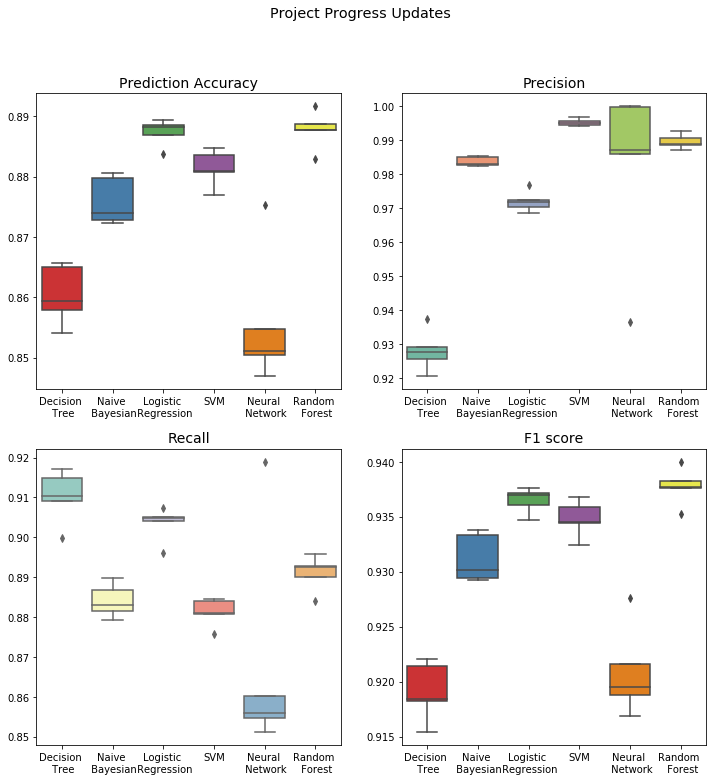

model= tree Mean of F1_score_result0 is:  0.9191134186691506  key_winner= svm
model= NB Mean of F1_score_result0 is:  0.9312057691234964  key_winner= tree
model= LR Mean of F1_score_result0 is:  0.9365064055304272  key_winner= NB
model= svm Mean of F1_score_result0 is:  0.934808212442479  key_winner= LR
model= nn Mean of F1_score_result0 is:  0.9208725020224525  key_winner= LR
model= RF Mean of F1_score_result0 is:  0.9377535534130772  key_winner= LR
*****winning model is:  RF  objective(F1 score)=  0.9377535534130772 *****
finished dealing  Project Progress Updates  , it takes time  45.396 s
==== I am dealing with the column:  Legitimation from Government Regulations


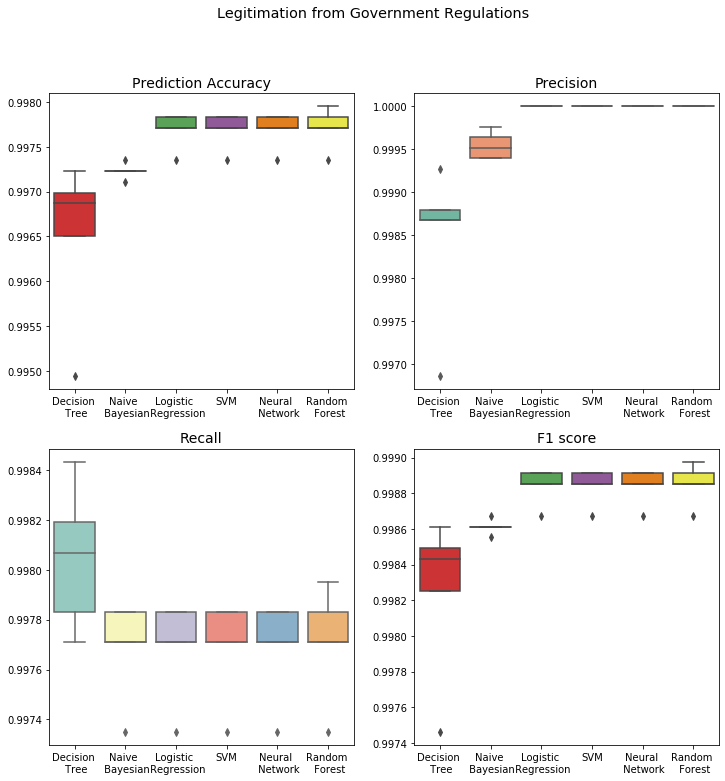

model= tree Mean of F1_score_result0 is:  0.9982501520431575  key_winner= svm
model= NB Mean of F1_score_result0 is:  0.9986133704618853  key_winner= tree
model= LR Mean of F1_score_result0 is:  0.9988427242594238  key_winner= NB
model= svm Mean of F1_score_result0 is:  0.9988427242594238  key_winner= LR
model= nn Mean of F1_score_result0 is:  0.9988427242594238  key_winner= LR
model= RF Mean of F1_score_result0 is:  0.9988547659101963  key_winner= LR
*****winning model is:  RF  objective(F1 score)=  0.9988547659101963 *****
finished dealing  Legitimation from Government Regulations  , it takes time  10.808 s
==== I am dealing with the column:  Media coverage


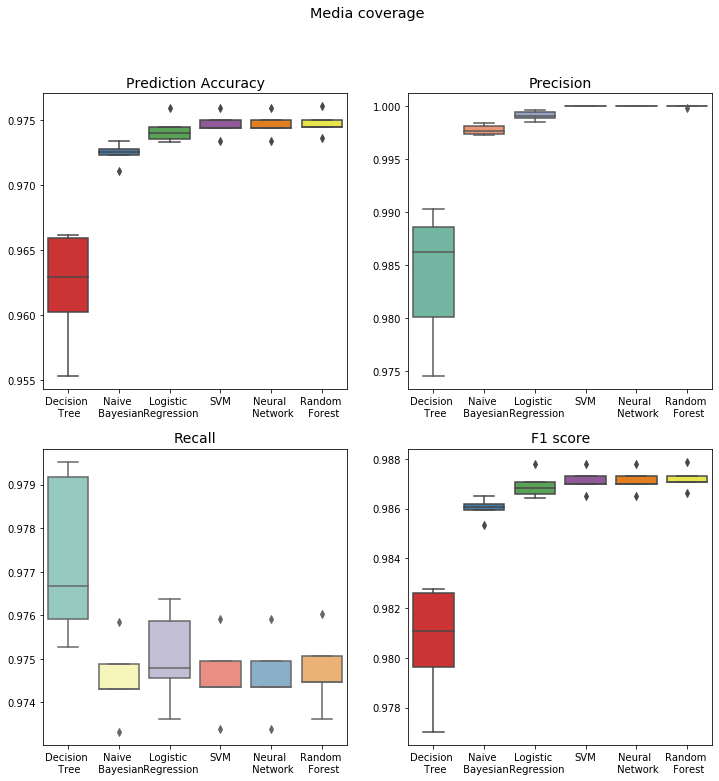

model= tree Mean of F1_score_result0 is:  0.9806254122951767  key_winner= svm
model= NB Mean of F1_score_result0 is:  0.9860202413119371  key_winner= tree
model= LR Mean of F1_score_result0 is:  0.9869414894961311  key_winner= NB
model= svm Mean of F1_score_result0 is:  0.9871331825290296  key_winner= LR
model= nn Mean of F1_score_result0 is:  0.9871331825290296  key_winner= svm
model= RF Mean of F1_score_result0 is:  0.9871930728326556  key_winner= svm
*****winning model is:  RF  objective(F1 score)=  0.9871930728326556 *****
finished dealing  Media coverage  , it takes time  26.137 s


In [125]:
df_columns = ['Disrupt traditional players',
       'Complement traditional players', 'Differentiate from new players',
       'Collaborate with new players', 'Build own community',
       'Differentiation without a Comparison', 'Project Progress Updates',
       'Legitimation from Government Regulations', 'Media coverage']

for column in df_columns:
    print("==== I am dealing with the column: ",column)
    outputDF = df[column]
    accuracy_result0 = {'tree':list(),'NB':list(),'LR':list(),'svm':list(),'nn':list(),'RF':list(),\
                       #'LDA':list(),'QDA':list()
                       }
    recall_result0 = {'tree':list(),'NB':list(),'LR':list(),'svm':list(),'nn':list(),'RF':list(),\
                       #'LDA':list(),'QDA':list()
                     }
    precision_result0 = {'tree':list(),'NB':list(),'LR':list(),'svm':list(),'nn':list(),'RF':list(),\
                       #'LDA':list(),'QDA':list()
                        }
    F1_score_result0 = {'tree':list(),'NB':list(),'LR':list(),'svm':list(),'nn':list(),'RF':list(),\
                       #'LDA':list(),'QDA':list()
                       }
    num_loop = 5 # repeat 5 times
    
    start_time = time.time()
    for j in range(num_loop):
        x_train,x_test,y_train,y_test = train_test_split\
            (inputDF,outputDF,shuffle=True,random_state=10 * j,test_size=0.8) # 80% for train, 20% for test
        train_features = Zhiyuan_count_vec.fit_transform(x_train)
        test_features = Zhiyuan_count_vec.transform(x_test)
        
        # Decision tree 
        accuracy,precision,recall,F1_score = fit_model(model=clf_tree,train_features=train_features,\
                                              test_features=test_features,y_train=y_train,y_test=y_test)
        accuracy_result0['tree'].append(accuracy)
        recall_result0['tree'].append(recall)
        precision_result0['tree'].append(precision)
        F1_score_result0['tree'].append(F1_score)

        # RandomForestClassifier
        accuracy,precision,recall,F1_score = fit_model(model=clf_RF,train_features=train_features,\
                                              test_features=test_features,y_train=y_train,y_test=y_test)
        accuracy_result0['RF'].append(accuracy)
        recall_result0['RF'].append(recall)
        precision_result0['RF'].append(precision)
        F1_score_result0['RF'].append(F1_score)

        # MultinomialNB
        accuracy,precision,recall,F1_score = fit_model(model=clf_NB,train_features=train_features,\
                                              test_features=test_features,y_train=y_train,y_test=y_test)
        accuracy_result0['NB'].append(accuracy)
        recall_result0['NB'].append(recall)
        precision_result0['NB'].append(precision)
        F1_score_result0['NB'].append(F1_score)

        # LogisticRegression
        accuracy,precision,recall,F1_score = fit_model(model=clf_LR,train_features=train_features,\
                                              test_features=test_features,y_train=y_train,y_test=y_test)
        accuracy_result0['LR'].append(accuracy)
        recall_result0['LR'].append(recall)
        precision_result0['LR'].append(precision)
        F1_score_result0['LR'].append(F1_score)

        # svm
        accuracy,precision,recall,F1_score = fit_model(model=clf_svm,train_features=train_features,\
                                              test_features=test_features,y_train=y_train,y_test=y_test)
        accuracy_result0['svm'].append(accuracy)
        recall_result0['svm'].append(recall)
        precision_result0['svm'].append(precision)
        F1_score_result0['svm'].append(F1_score)
        
        # LinearDiscriminantAnalysis
        '''
        accuracy,precision,recall,F1_score = fit_model(model=clf_LDA,train_features=train_features.toarray(),\
                                              test_features=test_features.toarray(),y_train=y_train,y_test=y_test)
        accuracy_result0['LDA'].append(accuracy)
        recall_result0['LDA'].append(recall)
        precision_result0['LDA'].append(precision)
        F1_score_result0['LDA'].append(F1_score)
        
        # QuadraticDiscriminantAnalysis
        accuracy,precision,recall,F1_score = fit_model(model=clf_LDA,train_features=train_features.toarray(),\
                                              test_features=test_features.toarray(),y_train=y_train,y_test=y_test)
        accuracy_result0['QDA'].append(accuracy)
        recall_result0['QDA'].append(recall)
        precision_result0['QDA'].append(precision)
        F1_score_result0['QDA'].append(F1_score)
        '''

        # neural network (add more hidden layers can improve performance, but right now let's skip it)
        accuracy,precision,recall,F1_score = fit_model(model=clf_nn,train_features=train_features,\
                                              test_features=test_features,y_train=y_train,y_test=y_test)
        accuracy_result0['nn'].append(accuracy)
        recall_result0['nn'].append(recall)
        precision_result0['nn'].append(precision)
        F1_score_result0['nn'].append(F1_score)
    # end inner-for loop
    
    # plot the fitting result
    fig = plt.figure(figsize=(12,12))
    fig.suptitle(column,fontsize="x-large")
    
    plt.subplot(221)
    ax = sns.boxplot(data=pd.DataFrame.from_dict(accuracy_result0),palette="Set1")
    ax.set_title('Prediction Accuracy',fontsize=14)
    #ax.set_xlabel('Machine Learning Models',fontsize=14)
    #ax.set_ylabel('Prediction accuracy',fontsize=14)
    ax.set(xticklabels=['Decision \n Tree','Naive \n Bayesian','Logistic \n Regression','SVM','Neural \n Network','Random \n Forest'])

    plt.subplot(222)
    ax = sns.boxplot(data=pd.DataFrame.from_dict(precision_result0),palette="Set2")
    ax.set_title('Precision',fontsize=14)
    #ax.set_xlabel('Machine Learning Models',fontsize=14)
    #ax.set_ylabel('Precision',fontsize=14)
    ax.set(xticklabels=['Decision \n Tree','Naive \n Bayesian','Logistic \n Regression','SVM','Neural \n Network','Random \n Forest'])

    plt.subplot(223)
    ax = sns.boxplot(data=pd.DataFrame.from_dict(recall_result0),palette="Set3")
    ax.set_title('Recall',fontsize=14)
    #ax.set_xlabel('Machine Learning Models',fontsize=14)
    #ax.set_ylabel('Recall',fontsize=14)
    ax.set(xticklabels=['Decision \n Tree','Naive \n Bayesian','Logistic \n Regression','SVM','Neural \n Network','Random \n Forest'])

    plt.subplot(224)
    ax = sns.boxplot(data=pd.DataFrame.from_dict(F1_score_result0),palette="Set1")
    ax.set_title('F1 score',fontsize=14)
    #ax.set_xlabel('Machine Learning Models',fontsize=14)
    #ax.set_ylabel('F1 score',fontsize=14)
    ax.set(xticklabels=['Decision \n Tree','Naive \n Bayesian','Logistic \n Regression','SVM','Neural \n Network','Random \n Forest'])
    
    fig.savefig(path + column +'_ML.png')
    plt.show()

    # the model selection is purly on F1 score
    # picking criteria (F1 score)
    # where Precision = # of 1 correctly identified / (# of 1 correctly identified + 0 incorrectly labelled as 1)
    objective = -1
    key_winner = 'svm' # by default, use SVM
    for key in accuracy_result0.keys():
        print("model=",key,"Mean of F1_score_result0 is: ",np.mean(F1_score_result0[key]), " key_winner=",key_winner)
        if ( np.mean(F1_score_result0[key]) ) > objective:
            key_winner = key
            objective = np.mean(F1_score_result0[key])
    print("*****winning model is: ", key_winner, " objective(F1 score)= ",objective,"*****")

    # once the model is known, use all data to train 
    # referred from https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
    all_features = Zhiyuan_count_vec.fit_transform(inputDF)
    if key_winner=='tree':
        clf_tree.fit(all_features,outputDF)
        save_winning_model(clf_tree,key_winner)
    elif key_winner=='NB':
        clf_NB.fit(all_features,outputDF)
        save_winning_model(clf_NB,key_winner)
    elif key_winner=='LR':
        clf_LR.fit(all_features,outputDF)
        save_winning_model(clf_LR,key_winner)
    elif key_winner=='svm':
        clf_svm.fit(all_features,outputDF)
        save_winning_model(clf_svm,key_winner)
    elif key_winner=='RF':
        clf_RF.fit(all_features,outputDF)
        save_winning_model(clf_RF,key_winner)
    else: # key_winnner=='nn'
        clf_nn.fit(all_features,outputDF)
        save_winning_model(clf_nn,key_winner)
    
    print("finished dealing ",column, " , it takes time ", round(time.time() - start_time,3),"s" )

# Section C: use TfidfVectorizer, train on different models and compare performance

In [59]:
# It is late mid-night, I am so tired...

# check this later:
# https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/

# Section D: high-frequence words for each category

In [126]:
import csv

def save_Counter(tuples,name):
    f = open(path + name + '_frequent_words.csv','w+')
    for t in tuples:
        line = ','.join(str(x) for x in t)
        f.write(line + '\n')
    f.close()

In [127]:
df_columns = ['Disrupt traditional players',
       'Complement traditional players', 'Differentiate from new players',
       'Collaborate with new players', 'Build own community',
       'Differentiation without a Comparison', 'Project Progress Updates',
       'Legitimation from Government Regulations', 'Media coverage']

for column in df_columns:
    index = []
    for i in range(len(df[column])):
        if df[column][i] == 1:
            index.append(i)
    print("==== I am dealing with the column: ",column, "find ", len(index), " rows having 1")
    inputDF2 = []
    for i in index:
        inputDF2.append(inputDF[i])
    inputDF2 = ' '.join(inputDF2)
    list_of_words = inputDF2.split(' ')
    count = Counter(list_of_words) 
    most_occur = count.most_common(5) 
    print("top 5 frequent words:  ", most_occur)
    print("save top 200 frequent words to file")
    save_Counter(count.most_common(200),column)
    

==== I am dealing with the column:  Disrupt traditional players find  57  rows having 1
top 5 frequent words:   [('mention', 55), ('the', 40), ('ethereum', 26), ('of', 25), ('``', 19)]
save top 200 frequent words to file
==== I am dealing with the column:  Complement traditional players find  74  rows having 1
top 5 frequent words:   [('mention', 56), ('to', 41), ('the', 36), ('with', 31), ('ont', 29)]
save top 200 frequent words to file
==== I am dealing with the column:  Differentiate from new players find  497  rows having 1
top 5 frequent words:   [('mention', 801), ('the', 482), ('bitcoin', 351), ('to', 335), ('is', 318)]
save top 200 frequent words to file
==== I am dealing with the column:  Collaborate with new players find  556  rows having 1
top 5 frequent words:   [('mention', 486), ('to', 343), ('the', 336), ('and', 254), ('etc', 226)]
save top 200 frequent words to file
==== I am dealing with the column:  Build own community find  2508  rows having 1
top 5 frequent words:  

# Section E: more analysis on significant texts for the categorical labels

In [128]:
# I will do it when I have time...